In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scispec

Based on https://opg.optica.org/ol/fulltext.cfm?uri=ol-32-8-970&id=131277
Trying to replicate the results from appendix of https://www.nature.com/articles/s41586-021-03602-3
In polar coordinates

### Just setting up some parameters here

In [3]:
c = 3*10**8 # speed of light
eps0 = 8.854*10**(-12) # permittivity of free space
wavelength = 1064*10**(-9) # wavelength of light
omega = 2*np.pi*c/wavelength # frequency of light

###
n1 = 1.0 # referactive index of air
n3 = 1.0
###

k0 = omega/c # Wavenumber of light in vacuum
k1 = k0*n1 # Wavenumber in first material
k3 = k0*n3 # wavenumber in secondimagevalue for now based on a magnification of 8.5 being best
f1 = 1.4*10**(-3) # this is the vienna value for now based on a magnification of 8.5 being best
f3 = 15.3*10**(-3) # just a value for now
M = f3/f1 # Magnification - f3 is the variable we want to optimise
print(M)
z3 = 0 #?????? position of fibre, origin at dipole??????

10.928571428571429


### Defining some function to make things cleaner lower down

In [4]:
def g_theta(theta):
    g = (1-(np.sin(theta)/M)**2)**(1/2)
    return g

def f_theta(theta):
    f = np.exp(1j*k3*z3*g_theta(theta))*(np.cos(theta)/g_theta(theta))**(1/2)*np.sin(theta)
    return f

### Doing the calculations here

In [5]:
NA = 0.95 # NA of trapping/collection lens
thetamax = np.arcsin(NA) # Max angle of light collection
theta = np.linspace(0, thetamax, 1000) # Want from 0 to max angle for light collection
C = 1j*k0**3*(n1*n3)**(1/2)*np.exp(1j*f1*(k1-k3*M))/(8*np.pi*M*eps0) # This is some complicated factor
dx = 1 # Dipole moment I think, we want in all in one direction 
rho3 = np.linspace(0, 25*10**(-6), 1000) # Distance from fibre axis

# First calculation is calculating values of intergrals as a function of distance from fibre axis

Id0 = []
Id2 = []
Id12 = []
ft = f_theta(theta)
gt = g_theta(theta)
ct = np.cos(theta)
st = np.sin(theta)
for i in rho3:
    arg = 1.3*k0*i/M*np.sin(theta)
    Id0_tmp = np.trapz(ft*(1+ct*gt)*scispec.jv(0, arg), theta) # integral over theta
    Id2_tmp = np.trapz(ft*(1-ct*gt)*scispec.jv(2, arg), theta) # integral over theta
    Id12_tmp = np.trapz(ft*ct*st*M**(-2)*scispec.jv(1, arg), theta) # integral over theta
    Id0.append(Id0_tmp)
    Id2.append(Id2_tmp)
    Id12.append(Id12_tmp)

In [6]:
phi3l = np.linspace(0, 2*np.pi, 100) # Full rotation in phi at fibre

#Second calculation is to find Electric field vector as a function of phi3

Ex3_r_l = []
Ex3_theta_l = []
Ex3_z_l = []
for phi3 in phi3l:
    Ex3_r = C*dx*(np.array(Id0) + np.array(Id2)*np.cos(2*phi3)) # Id0 and Id2 are integrals, phi3 is phi coordiante for fibre objective lens
    Ex3_theta = C*dx*(np.array(Id2)*np.sin(2*phi3)) 
    Ex3_z = C*dx*(-2j*np.array(Id12)*np.sin(2*phi3)) # Id12 is integrals
    Ex3_r_l.append(Ex3_r)
    Ex3_theta_l.append(Ex3_theta)
    Ex3_z_l.append(Ex3_z)

In [8]:
np.asarray(Ex3_r_l).shape

(100, 1000)

So now we have the image of the dipole at the input to the fibre as a function of distance from the centre of the fibre and angle. As expected this is symmetric in a rotation of $\pi$.

C:\Users\yuhan\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\yuhan\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\yuhan\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\yuhan\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Normalised electric field')

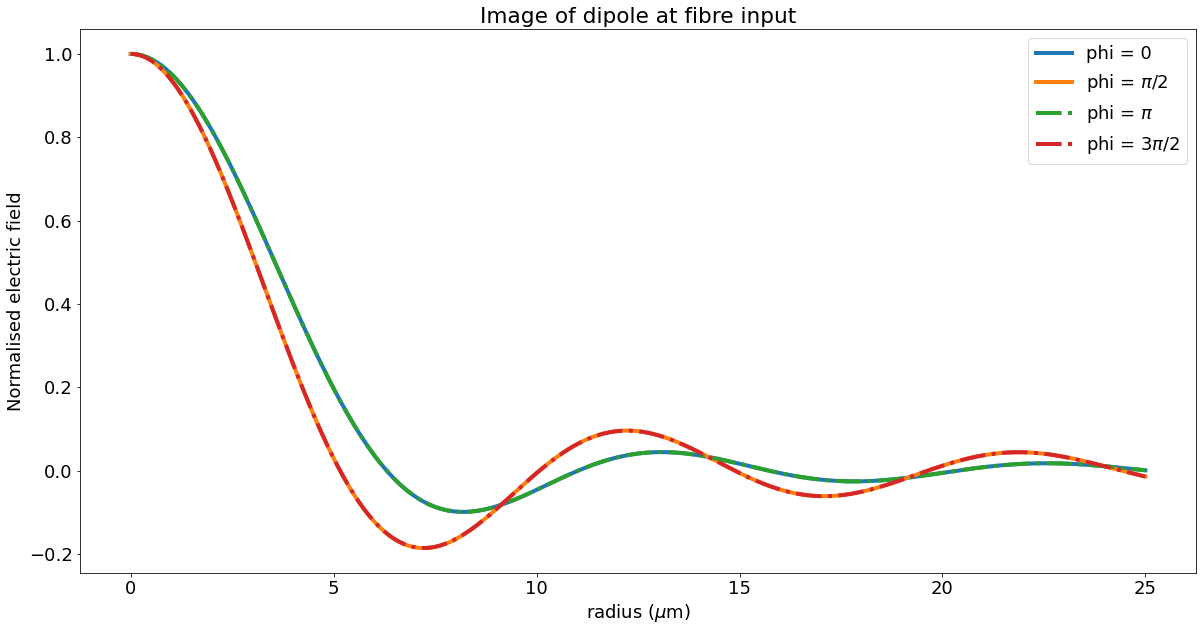

In [7]:
plt.rc('font', size = 18)
plt.figure(figsize = (20,10))
plt.title('Image of dipole at fibre input')
plt.plot(rho3*10**6, Ex3_r_l[0]/Ex3_r_l[0][0], linewidth = 4, label = 'phi = 0')
plt.plot(rho3*10**6, Ex3_r_l[25]/Ex3_r_l[25][0], linewidth = 4, label = 'phi = $\pi/2$')
plt.plot(rho3*10**6, Ex3_r_l[50]/Ex3_r_l[50][0], '-.', linewidth = 4, label = 'phi = $\pi$')
plt.plot(rho3*10**6, Ex3_r_l[75]/Ex3_r_l[75][0], '-.', linewidth = 4, label = 'phi = $3\pi/2$')

plt.legend()
plt.xlabel('radius ($\mu$m)')
plt.ylabel('Normalised electric field')

In [9]:
# Now fibre mode electric field

a = 2.5*10**(-6) # Core size

###
# This parameters I'm just guessing basically - I have no idea what they are in the Vienna set up.
nco = 1.45 # Index of refraction - core
ncl = 1.44 # Index of refraction - cladding
beta = nco*k0*0.9968 # Derived from fribre V-parameter, V^2 = u^2+w^2
###

u = a*np.sqrt(nco**2*k0**2 - beta**2) # Transverse wave vector in core
w = a*np.sqrt(beta**2 - ncl**2*k0**2) # Transverse wave vector in cladding
print('V-parameter:  ' + str(np.sqrt(w**2+u**2)))

r = np.linspace(0, a, 1000) # Radius in core
Ex_01 = scispec.jv(0, u*r/a) # electric field in core, r<a

r2 = np.linspace(a, 20*10**(-6), 9000) # Radius in cladding
Ex_01_2 = scispec.jv(0, u)/scispec.kv(0, w)*scispec.kv(0, w*r2/a) # electric field in cladding, r>a


V-parameter:  2.5097309732625366


Text(0, 0.5, 'Normalised electric field')

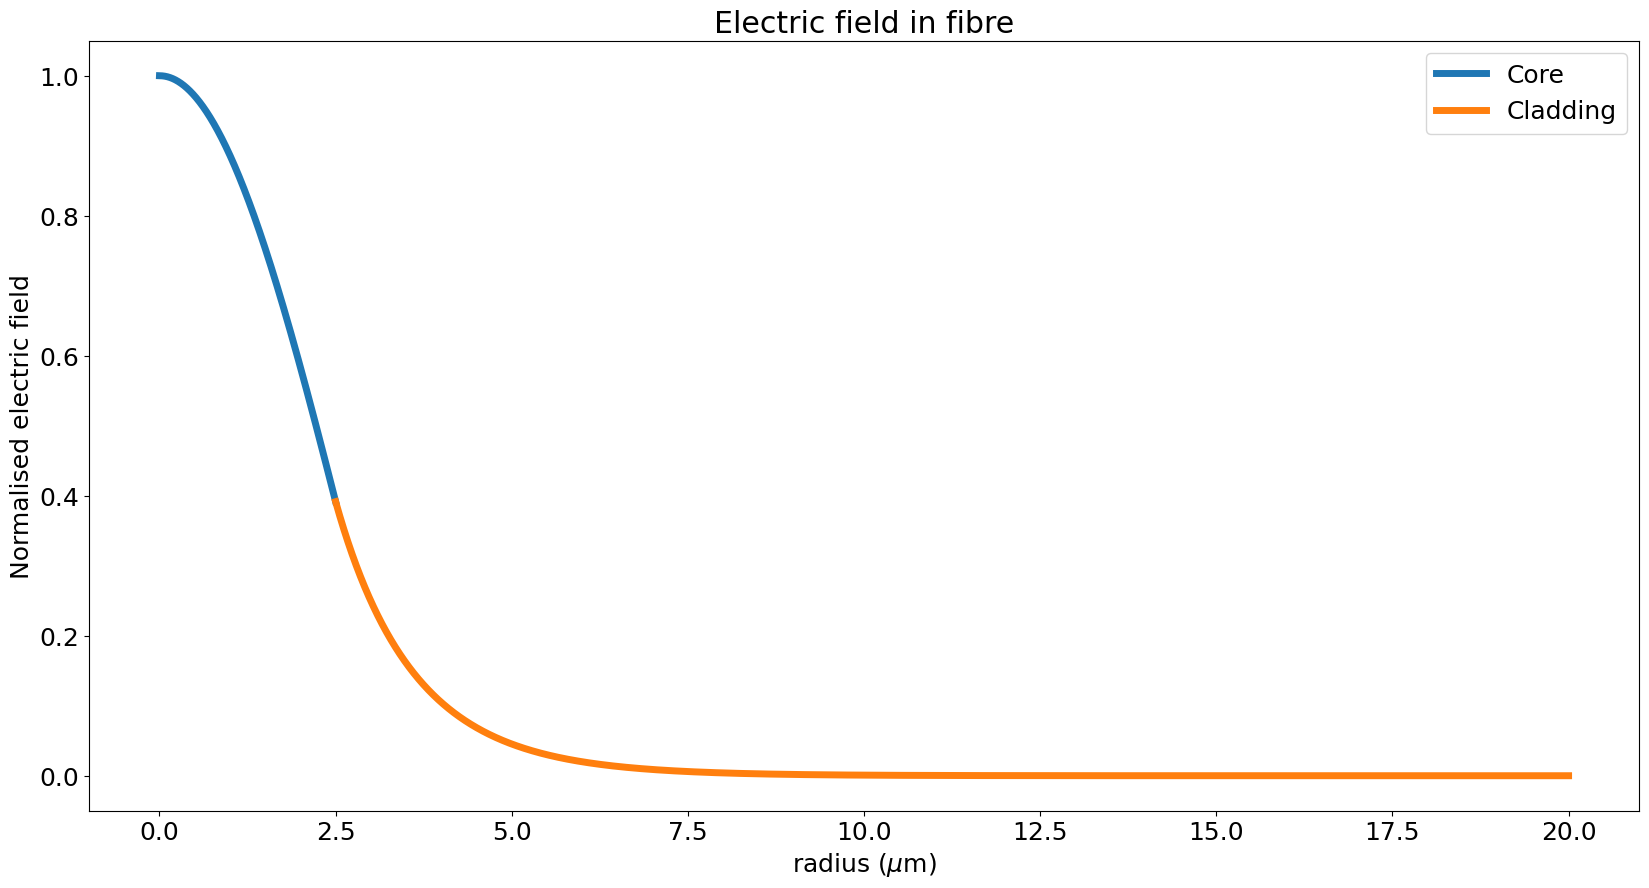

In [10]:
plt.rc('font', size = 18)
plt.figure(figsize = (20,10))
plt.title('Electric field in fibre')
plt.plot(r*10**6, Ex_01, label = 'Core', linewidth = 5) 
plt.plot(r2*10**6, Ex_01_2, label = 'Cladding', linewidth = 5) 
plt.legend()
plt.xlabel('radius ($\mu$m)')
plt.ylabel('Normalised electric field')

Text(0, 0.5, 'Normalised electric field')

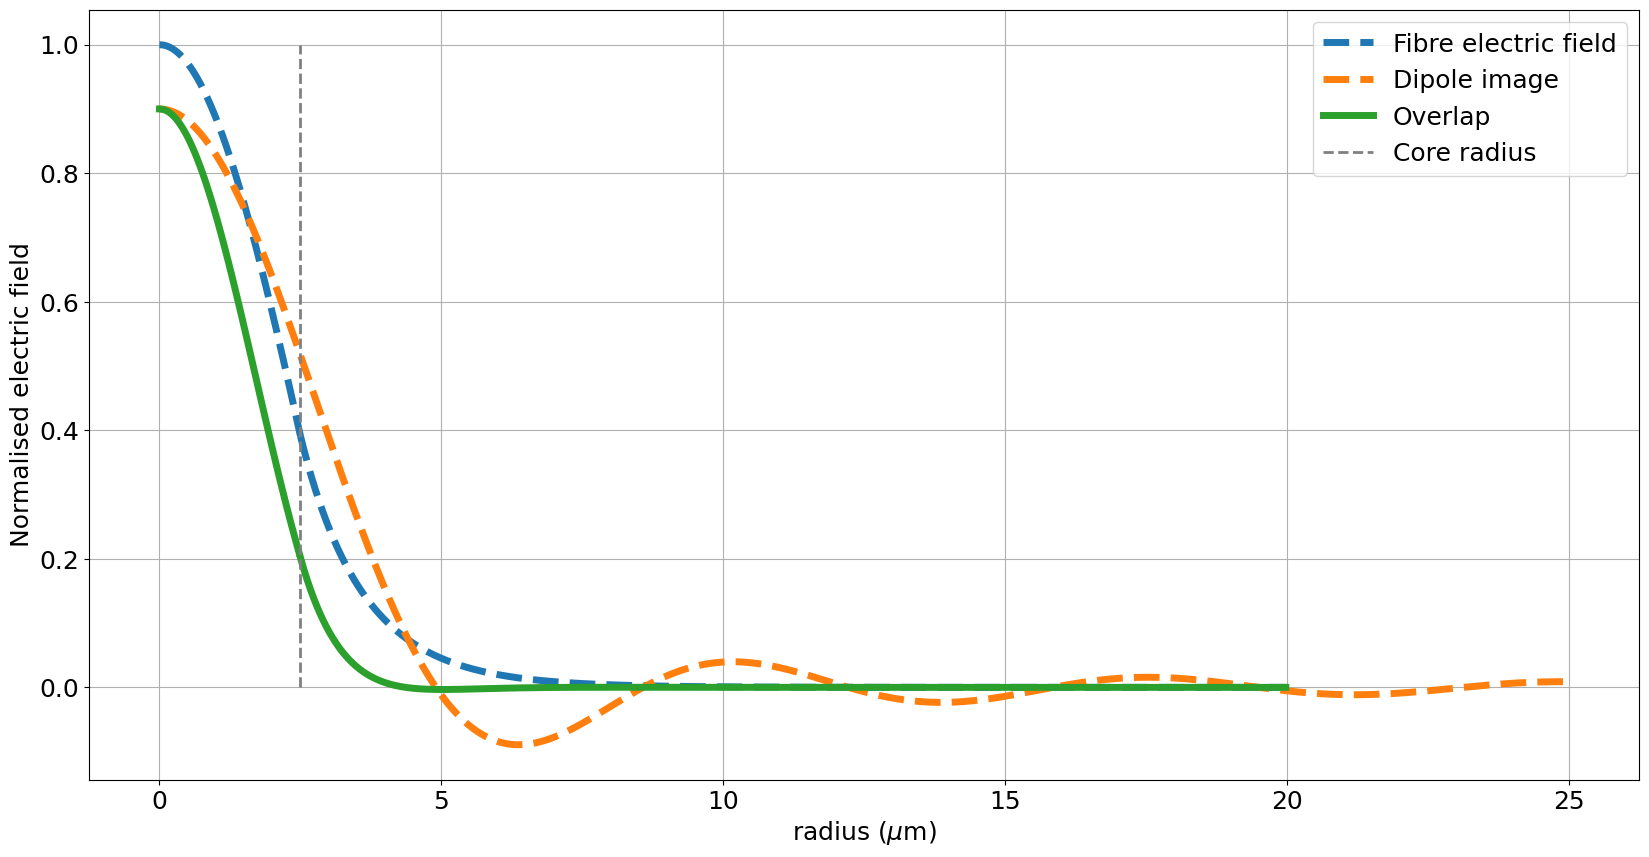

In [11]:
plt.rc('font', size = 18)
plt.figure(figsize = (20,10))
plt.grid()
plt.plot(r*10**6, Ex_01, '--', linewidth = 5, label = 'Fibre electric field') 
plt.plot(r2*10**6, Ex_01_2, '--', color = 'tab:blue', linewidth = 5)
plt.plot(rho3*10**6, 0.9*Ex3_r_l[0]/Ex3_r_l[0][0], '--',  linewidth = 5, label = 'Dipole image') # Note I've scaled the dipole image to be ~0.9 and 0 radius to match the Vienna paper
plt.plot(r[::10]*10**6, 0.9*Ex_01[::10]*Ex3_r_l[0][:100]/Ex3_r_l[0][0], linewidth = 5)
plt.plot(r2[::10]*10**6, 0.9*Ex_01_2[::10]*Ex3_r_l[0][100:]/Ex3_r_l[0][0], color = 'tab:green', linewidth = 5, label = 'Overlap')
plt.plot([a*10**6, a*10**6], [0, 1], '--', color = 'gray', linewidth = 2, label = 'Core radius')
plt.legend()
plt.xlabel('radius ($\mu$m)')
plt.ylabel('Normalised electric field')
#plt.plot(rho3*10**6, 10**(-32)*Ex3_phi)
#plt.plot(rho3*10**6, 10**(-32)*Ex3_theta)

In [12]:
overlapl = []
for i in range(len(phi3l)): 
    overlap_tmp = np.abs(np.trapz(Ex_01[::10]*Ex3_r_l[i][:100], r[::10]) + np.trapz(Ex_01_2[::10]*Ex3_r_l[i][100:], r2[::10]))
    overlapl.append(overlap_tmp)
overlap = np.trapz(overlapl, phi3l)**2
print(overlap)

1.254867538477682e+48


In [13]:
dipolel = []
for i in range(len(phi3l)):
    dipole_tmp = np.trapz(np.abs(Ex3_r_l[i])**2, rho3)
    dipolel.append(dipole_tmp)
dipole = np.trapz(dipolel, phi3l)
print(dipole)

1.2685798348908624e+53


In [14]:
fibrel = []
for i in range(len(phi3l)):
    fibre_tmp = (np.trapz(Ex_01**2, r) + np.trapz(Ex_01_2**2, r2))
    fibrel.append(fibre_tmp)
fibre = np.trapz(fibrel, phi3l)
print(fibre)

1.067698926999894e-05


In [15]:
overlap/dipole/fibre

0.926469816486139

# Now loop over magnification and calculate efficiency

In [156]:
c = 3*10**8
eps0 = 8.854*10**(-12)
wavelength = 1064*10**(-9)
omega = 2*np.pi*c/wavelength
n1 = 1.5
n3 = 1.5
k0 = omega/c
k1 = k0*n1
k3 = k0*n3
f1 = 1.4*10**(-3) # this is the vienna value for now based on a magnification of 8.5 being best
f3 = 15.3*10**(-3) # just a value for now
M = f3/f1 # Magnification - f3 is the variable we want to optimise
z3 = 0 #?????? position of fibre, origin at dipole??????
rho3 = 0 #?????? think this is coordinate (polar) so 0 when not displaced 
etal = []
for M in np.arange(4, 20, 0.25):
    NA = 0.95
    thetamax = np.arcsin(NA)
    theta = np.linspace(0, thetamax, 1000)
    C = 1j*k0**3*(n1*n3)**(1/2)*np.exp(1j*f1*(k1-k3*M))/(8*np.pi*M*eps0)
    rho3 = np.linspace(0, 25*10**(-6), 1000)
    Id0 = []
    Id2 = []
    Id12 = []
    ft = f_theta(theta)
    gt = g_theta(theta)
    ct = np.cos(theta)
    st = np.sin(theta)
    for i in rho3:
        arg = 1.3*k0*i/M*np.sin(theta)
        Id0_tmp = np.trapz(ft*(1+ct*gt)*scispec.jv(0, arg), theta) # integral over theta
        Id2_tmp = np.trapz(ft*(1-ct*gt)*scispec.jv(2, arg), theta) # integral over theta
        Id12_tmp = np.trapz(ft*ct*st*M**(-2)*scispec.jv(1, arg), theta) # integral over theta
        Id0.append(Id0_tmp)
        Id2.append(Id2_tmp)
        Id12.append(Id12_tmp)
    ### What is dx??? Dipole? Let's say it's all in x
    phi3l = np.linspace(0, 2*np.pi, 100) #???
    #phi3 = np.pi
    dx = 1
    Ex3_r_l = []
    Ex3_theta_l = []
    Ex3_phi_l = []
    for phi3 in phi3l:
        Ex3_r = C*dx*(np.array(Id0) + np.array(Id2)*np.cos(2*phi3)) # Id0 and Id2 are integrals, phi3 is phi coordiante for fibre objective lens
        Ex3_theta = C*dx*(np.array(Id2)*np.sin(2*phi3)) 
        Ex3_phi = C*dx*(-2j*np.array(Id12)*np.sin(2*phi3)) # Id12 is integrals
        Ex3_r_l.append(Ex3_r)
        Ex3_theta_l.append(Ex3_theta)
        Ex3_phi_l.append(Ex3_phi)
    # Now fibre mode electric field
    a = 2.5*10**(-6)
    r = np.linspace(0, a, 1000)
    nco = 1.45
    ncl = 1.44
    beta = nco*k0*0.9968
    u = a*np.sqrt(nco**2*k0**2 - beta**2)
    w = a*np.sqrt(beta**2 - ncl**2*k0**2)
    #print(np.sqrt(w**2+u**2))
    arg2 = u*r/a
    Ex_01 = scispec.jv(0, arg2) # r<a
    r2 = np.linspace(a, 20*10**(-6), 9000)
    Ex_01_2 = scispec.jv(0, u)/scispec.kv(0, w)*scispec.kv(0, w*r2/a) # r>a
    sum_E = np.sum(Ex_01)+np.sum(Ex_01_2)
    #Ex_01 = Ex_01/sum_E
    #Ex_01_2 = Ex_01_2/sum_E
    overlapl = []
    for i in range(len(phi3l)):
        overlap_tmp = np.abs(np.trapz(Ex_01[::10]*Ex3_r_l[i][:100], r[::10]) + np.trapz(Ex_01_2[::10]*Ex3_r_l[i][100:], r2[::10]))
        #overlap_tmp = np.abs(np.trapz(Ex_01[::10]*Ex3_r_l[i][:100], r[::10]))
        overlapl.append(overlap_tmp)
    overlap = np.trapz(overlapl, phi3l)**2
    dipolel = []
    for i in range(len(phi3l)):
        dipole_tmp = np.trapz(np.abs(Ex3_r_l[i])**2, rho3)
        dipolel.append(dipole_tmp)
    dipole = np.trapz(dipolel, phi3l)
    fibrel = []
    for i in range(len(phi3l)):
        fibre_tmp = (np.trapz(Ex_01**2, r) + np.trapz(Ex_01_2**2, r2))
        fibrel.append(fibre_tmp)
    fibre = np.trapz(fibrel, phi3l)
    eta = overlap/dipole/fibre
    etal.append(eta)
    #print('yes')

Text(0, 0.5, 'Collection efficiency')

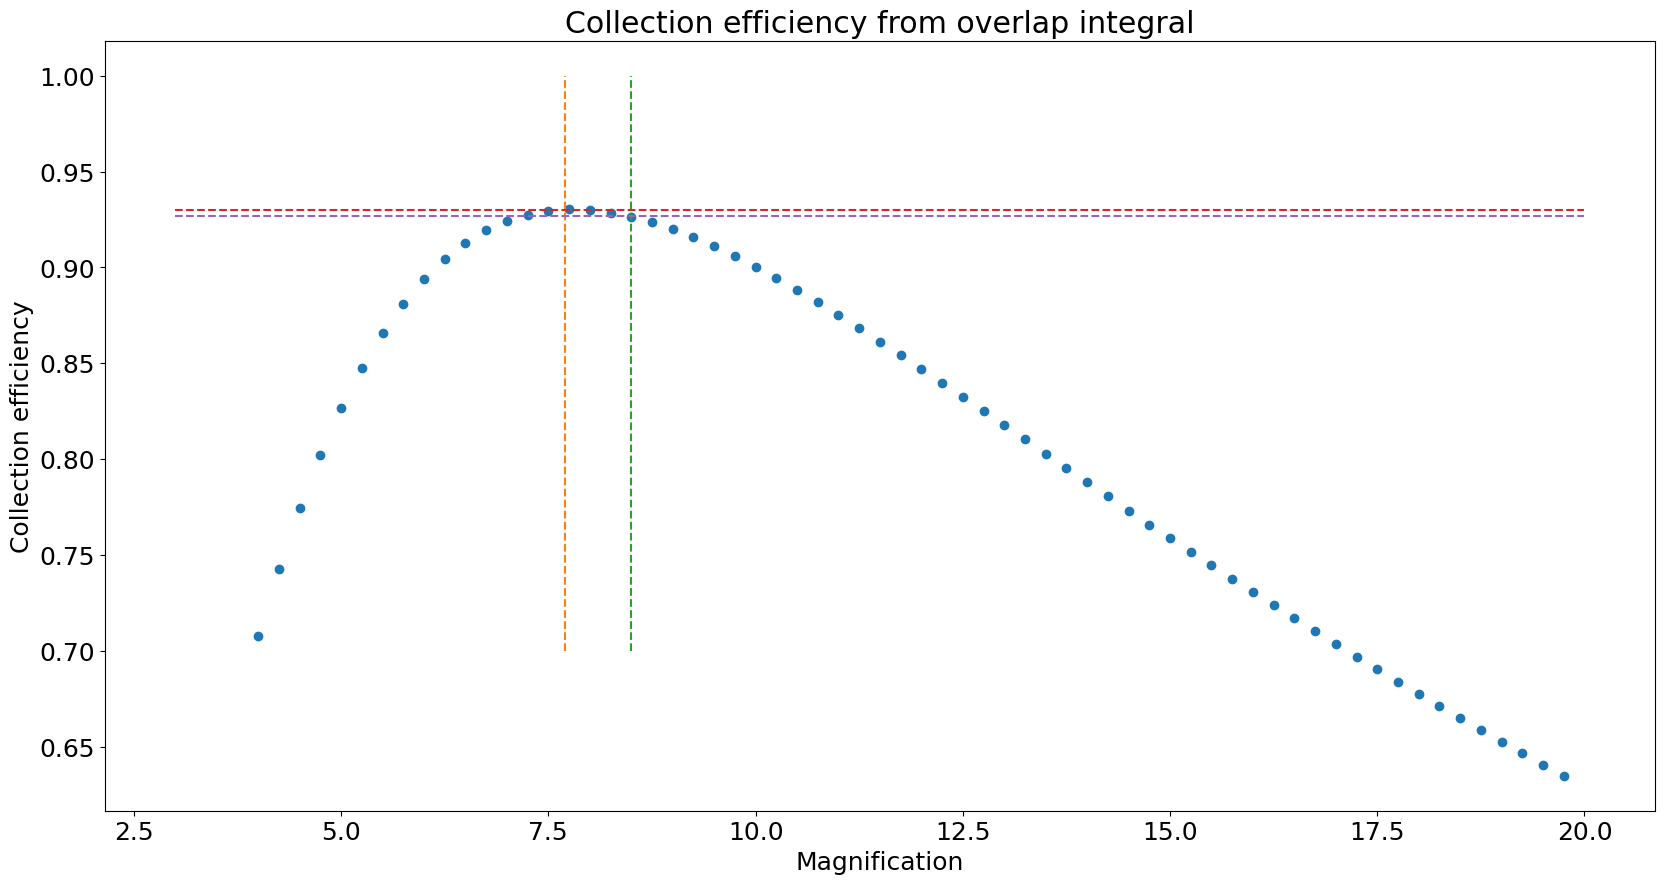

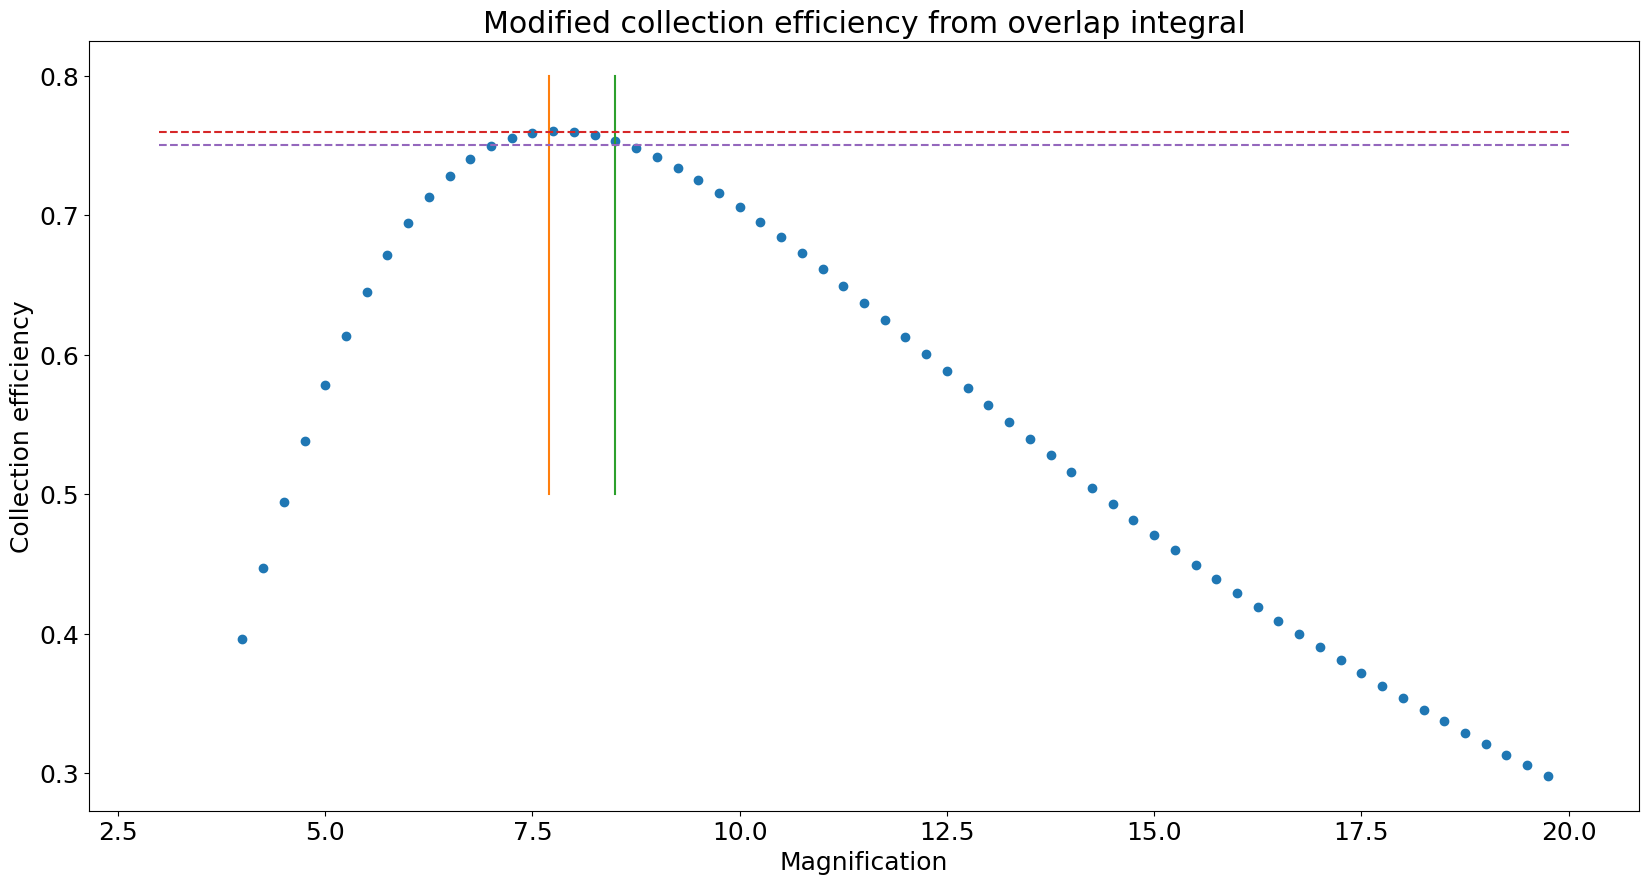

In [157]:
plt.figure(figsize = (20,10))
plt.title('Collection efficiency from overlap integral')
plt.plot(np.arange(4, 20, 0.25),np.array(etal[:]), 'o')
plt.plot([7.7, 7.7], [0.7, 1.0], '--')
plt.plot([8.5, 8.5], [0.7, 1.0], '--')
plt.plot([3, 20], [0.93, 0.93], '--')
plt.plot([3, 20], [0.927, 0.927], '--')
plt.xlabel('Magnification')
plt.ylabel('Collection efficiency')

# Now modify to make it similar to Vienna paper

plt.figure(figsize = (20,10))
plt.title('Modified collection efficiency from overlap integral')
plt.plot(np.arange(4, 20, 0.25),np.array(etal[:])**2-0.105, 'o')
plt.plot([7.7, 7.7], [0.5, 0.8])
plt.plot([8.5, 8.5], [0.5, 0.8])
plt.plot([3, 20], [0.76, 0.76], '--')
plt.plot([3, 20], [0.75, 0.75], '--')
plt.xlabel('Magnification')
plt.ylabel('Collection efficiency')